In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn import metrics

In [2]:
# 載入數據
data = pd.read_csv(r'C:\Users\user\Desktop\test\fea_9\fea_9_notime.csv')

In [3]:
# 將數據轉換為numpy數組
data = data.values

# 將數據分為特徵和目標值
X = data[:, :-1]
y = data[:, -1]

# 將數據正規化
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))

In [4]:
# 定義函數將數據轉換為具有6個時間步長的序列
def create_sequence(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

# 將數據轉換為具有6個時間步長的序列
time_steps = 3
X, y = create_sequence(X, y, time_steps)

# 將數據集分為訓練集、驗證集和測試集
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# 訓練集、驗證集和測試集的形狀
print('訓練集:', X_train.shape, y_train.shape)
print('驗證集:', X_val.shape, y_val.shape)
print('測試集:', X_test.shape, y_test.shape)

訓練集: (82036, 3, 9) (82036, 1)
驗證集: (27345, 3, 9) (27345, 1)
測試集: (27346, 3, 9) (27346, 1)


In [5]:
# LSTM模型
def build_model(units, batch_size, epochs, learning_rate):
    model = Sequential()
    model.add(LSTM(int(units), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.add(LSTM(int(units), return_sequences=True))
    model.add(Dense(1))
    model.add(LSTM(int(units), return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1,activation='linear'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    history = model.fit(X_train, y_train, batch_size=int(batch_size), epochs=int(epochs),
                        validation_data=(X_val, y_val), verbose=0)
    return history.history['val_loss'][-1]

In [6]:
# 定義超參數空間
pbounds = {'units': (64, 256),
           'batch_size': (8, 64),
           'epochs': (10, 40),
           'learning_rate': (0.0001, 0.01)}

In [7]:
# Bayes優化
optimizer = BayesianOptimization(f=build_model, pbounds=pbounds, verbose=1,random_state=4)
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | batch_... |  epochs   | learni... |   units   |
-------------------------------------------------------------------------
| 2         | 0.007315  | 47.07     | 16.48     | 0.009765  | 65.2      |
| 5         | 0.007523  | 8.503     | 21.6      | 0.0005372 | 247.7     |
| 7         | 0.007558  | 16.46     | 38.59     | 0.006313  | 254.2     |
| 8         | 0.008453  | 8.104     | 39.43     | 0.008979  | 230.9     |


In [8]:
# 獲取最佳參數值
best_params = optimizer.max['params']
units = int(best_params['units'])
batch_size = int(best_params['batch_size'])
epochs = int(best_params['epochs'])
learning_rate = best_params['learning_rate']

print('units:',units)
print('batch_size:',batch_size)
print('epochs:',epochs)
print('learning_rate:',learning_rate)

units: 230
batch_size: 8
epochs: 39
learning_rate: 0.008978888637724515


Epoch 1/39
10255/10255 [==============================] - 103s 10ms/step - loss: 0.0120 - val_loss: 0.0082
Epoch 2/39
10255/10255 [==============================] - 100s 10ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 3/39
10255/10255 [==============================] - 100s 10ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 4/39
10255/10255 [==============================] - 100s 10ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 5/39
10255/10255 [==============================] - 99s 10ms/step - loss: 0.0068 - val_loss: 0.0084
Epoch 6/39
10255/10255 [==============================] - 100s 10ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 7/39
10255/10255 [==============================] - 99s 10ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 8/39
10255/10255 [==============================] - 99s 10ms/step - loss: 0.0066 - val_loss: 0.0077
Epoch 9/39
10255/10255 [==============================] - 99s 10ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 10/39
10255/10255 [================

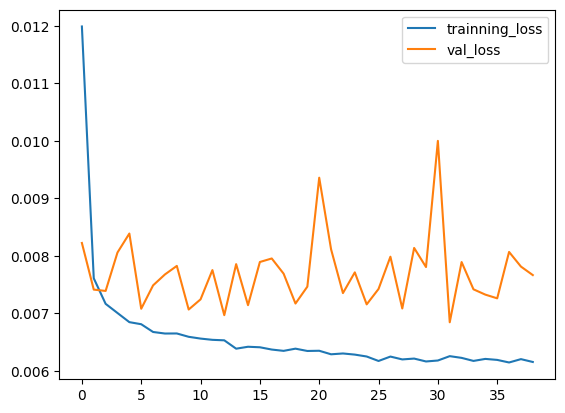

In [9]:
# 訓練LSTM模型
model = Sequential()
model.add(LSTM(int(units), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.add(LSTM(int(units), return_sequences=True))
model.add(Dense(1))
model.add(LSTM(int(units), return_sequences=True))
model.add(Flatten())
model.add(Dense(1,activation='linear'))
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, batch_size=int(batch_size), epochs=int(epochs),
                        validation_data=(X_val, y_val), verbose=1)

# 繪製trainning_loss和val_loss的曲線圖
plt.plot(history.history['loss'], label='trainning_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [10]:
# 使用測試集進行模型評估
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

MAPE: inf
RMSE: 247.58
MSE: 61294.08
MAE: 132.96
R2: 0.95


C:\Users\user\AppData\Local\Temp\ipykernel_16760\2600406015.py:1: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


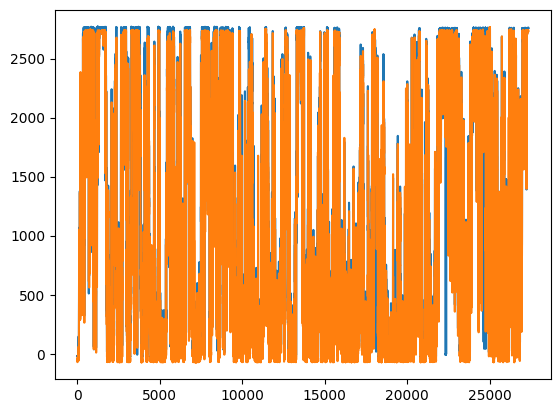

In [11]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
rmse = np.sqrt(np.mean(np.square(y_test - y_pred)))
mse = metrics.mean_squared_error(y_test,y_pred)
mae = metrics.mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print('MAPE: %.2f' % mape)
print('RMSE: %.2f' % rmse)
print('MSE: %.2f' % mse)
print('MAE: %.2f' % mae)
print('R2: %.2f' % r2)

plt.plot(y_test)
plt.plot(y_pred)
plt.show()

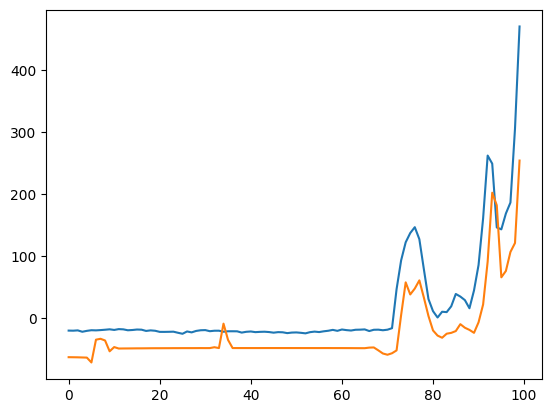

In [12]:
plt.plot(y_test[:100])
plt.plot(y_pred[:100])
plt.show()

In [13]:
y_test=pd.DataFrame(y_test)
y_pred=pd.DataFrame(y_pred)
X = pd.concat([y_test,y_pred],axis=1)
print(X)

                 0            0
0       -20.150000   -63.054161
1       -20.299999   -63.150410
2       -19.801666   -63.272282
3       -22.028334   -63.501530
4       -20.561666   -63.726730
...            ...          ...
27341  2757.728271  2732.181396
27342  2758.323242  2733.334717
27343  2759.243408  2727.279297
27344  2761.261719  2735.025146
27345  2758.593262  2737.177734

[27346 rows x 2 columns]
